# IMPORTING THE NECESSARY LIBRARIES AND TOOLS

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3, warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.3f}'.format)

#### LOADING AND FIRST INSPECTION

In [6]:
conn = sqlite3.connect('../data/creditdb.sqlite')
df = pd.read_sql_query('SELECT * FROM raw_credit_data', conn)
conn.close()
print(f'Rows: {len(df):,} | Columns: {df.shape[1]}')
df.head()


Rows: 150,000 | Columns: 12


,customer_id,defaulted,revolvingutilizationofunsecuredlines,age,numberoftime30_59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60_89dayspastduenotworse,numberofdependents
0,1,1,0.766,45,2,0.803,9120.000,13,0,6,0,2.000
1,2,0,0.957,40,0,0.122,2600.000,4,0,0,0,1.000
2,3,0,0.658,38,1,0.085,3042.000,2,1,0,0,0.000
3,4,0,0.234,30,0,0.036,3300.000,5,0,0,0,0.000
4,5,0,0.907,49,1,0.025,63588.000,7,0,1,0,0.000


#### DEALING WITH MISSING VALUES

In [7]:
missing = pd.DataFrame({
    'count': df.isnull().sum(),
    'pct': (df.isnull().mean() * 100).round(2).astype(str) + '%'
}).query('count > 0').sort_values('pct',ascending=False)
missing
# MonthlyIncome: ~19.8% missing -> fill with median
# NumberOfDependents: ~2.6% missing -> fill with 0


,count,pct
numberofdependents,3924,2.62%
monthlyincome,29731,19.82%


#### VISUALIZING CLASS IMBALANCE

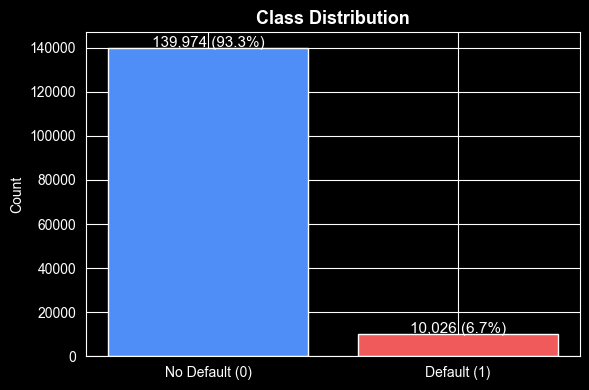

In [8]:
counts = df['defaulted'].value_counts()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(['No Default (0)', 'Default (1)'], counts.values,
       color=['#4f8ef7','#f05a5a'])
for i, v in enumerate(counts.values):
    ax.text(i, v + 500, f'{v:,} ({v/len(df)*100:.1f}%)',
            ha='center', fontsize=11)
ax.set_title('Class Distribution', fontsize=13, fontweight='bold')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('../docs/class_imbalance.png', dpi=150)
plt.show()

#### FEATURE DISTRIBUTION AND OUTLIERS

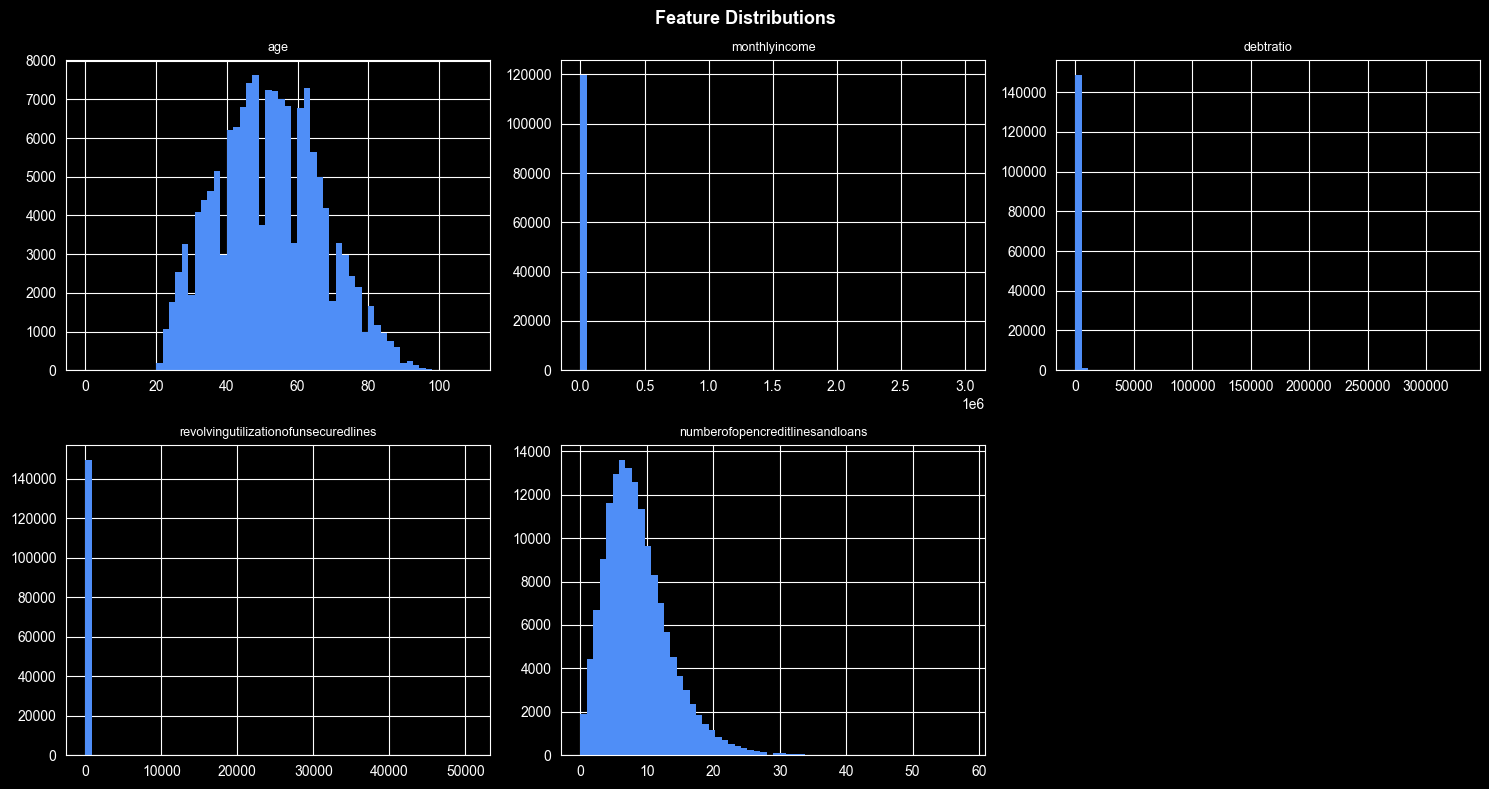

Max revolving utilization:  50708.0
Min age:  0


In [13]:
numerical = ['age', 'monthlyincome', 'debtratio', 'revolvingutilizationofunsecuredlines', 'numberofopencreditlinesandloans']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numerical):
    df[col].dropna().hist(bins=60, ax=axes[i], color='#4f8ef7', edgecolor='none')
    axes[i].set_title(col, fontsize=9)
    for ax in axes[len(numerical):]:
        ax.set_visible(False)
plt.suptitle('Feature Distributions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/distributions.png', dpi=150)
plt.show()

print('Max revolving utilization: ', df['revolvingutilizationofunsecuredlines'].max())
print('Min age: ', df['age'].min())
# You will see: utilisation values > 1 (impossible), one borrower aged 0


In [12]:
print(df.columns.tolist())

['customer_id', 'defaulted', 'revolvingutilizationofunsecuredlines', 'age', 'numberoftime30_59dayspastduenotworse', 'debtratio', 'monthlyincome', 'numberofopencreditlinesandloans', 'numberoftimes90dayslate', 'numberrealestateloansorlines', 'numberoftime60_89dayspastduenotworse', 'numberofdependents']


#### CORRELATIONS AND KEY FINDINGS

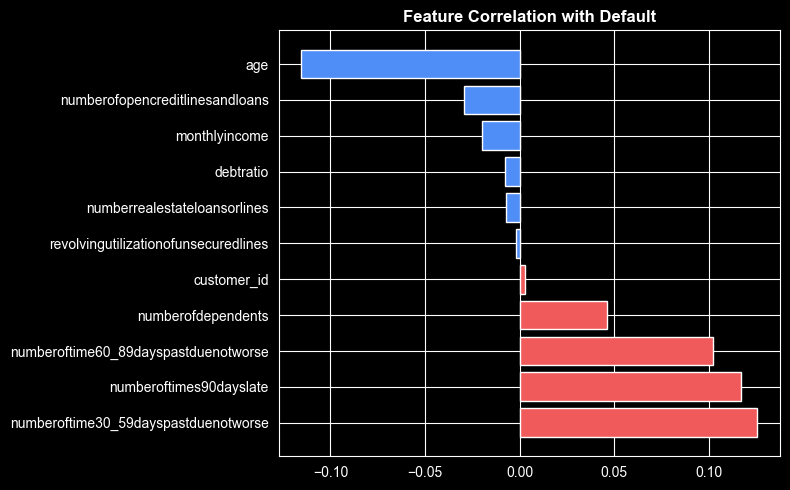

In [14]:
corr = df.corr()['defaulted'].sort_values(ascending=False).drop('defaulted')
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#f05a5a' if c > 0 else '#4f8ef7' for c in corr.values]
ax.barh(corr.index, corr.values, color=colors)
ax.axvline(0, color='white', linewidth=0.5)
ax.set_title('Feature Correlation with Default', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../docs/correlations.png', dpi=150)
plt.show()


Data Quality Issues -
 - MonthlyIncome: 19,8% missing - strategy: median imputation
 - NumberOfDependents: 2.6% missing - strategy: fill with 0
 - RevolvingUtilization: values > 1.0 exist - strategy: cap at 1
 - One borrower with age = 0 - strategy: drop row


Class Imbalance
 - 93.3% non-default/ 6.7% default
 - Accuracy isn't a valid metric for this
 - Selected metric: AUC-ROC

Strongest Predictors (linear correlation)
 - Positive: total late payments, revolving utilization
 - Negative: monthly income, age

In [15]:
findings = '''
Data Quality Issues -
 - MonthlyIncome: 19,8% missing - strategy: median imputation
 - NumberOfDependents: 2.6% missing - strategy: fill with 0
 - RevolvingUtilization: values > 1.0 exist - strategy: cap at 1
 - One borrower with age = 0 - strategy: drop row


Class Imbalance
 - 93.3% non-default/ 6.7% default
 - Accuracy isn't a valid metric for this
 - Selected metric: AUC-ROC

Strongest Predictors (linear correlation)
 - Positive: total late payments, revolving utilization
 - Negative: monthly income, age
'''

with open('../docs/eda_findings.md', 'w') as f:
    f.write(findings)